In [6]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv('/Users/tvvr/Downloads/churn-bigml-80.csv')
test_df = pd.read_csv('/Users/tvvr/Downloads/churn-bigml-20.csv')

# Display the first few rows of the training dataset
print("Training Dataset:")
print(train_df.head())

# Display the first few rows of the testing dataset
print("Testing Dataset:")
print(test_df.head())

# Summary statistics for training dataset
print("Training Dataset Summary:")
print(train_df.describe())

# Summary statistics for testing dataset
print("Testing Dataset Summary:")
print(test_df.describe())

# Check for missing values in the training dataset
print("Missing Values in Training Dataset:")
print(train_df.isnull().sum())

# Check for missing values in the testing dataset
print("Missing Values in Testing Dataset:")
print(test_df.isnull().sum())

# Get a summary of the columns in the training dataset
print("Training Dataset Columns:")
print(train_df.columns)

# Get a summary of the columns in the testing dataset
print("Testing Dataset Columns:")
print(test_df.columns)

Training Dataset:
  State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07              197.4               99             16.78   
1   

In [7]:
# Calculate total charges by summing all charge columns
train_df['total_charges'] = (train_df['Total day charge'] + 
                             train_df['Total eve charge'] + 
                             train_df['Total night charge'] + 
                             train_df['Total intl charge'])

test_df['total_charges'] = (test_df['Total day charge'] + 
                            test_df['Total eve charge'] + 
                            test_df['Total night charge'] + 
                            test_df['Total intl charge'])

# Assuming monthly_charges can be derived directly from total_charges by dividing by the account length
train_df['monthly_charges'] = train_df['total_charges'] / train_df['Account length']
test_df['monthly_charges'] = test_df['total_charges'] / test_df['Account length']

# Handle any potential missing or infinite values resulting from the calculations
train_df['total_charges'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
test_df['total_charges'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)

train_df['total_charges'].fillna(0, inplace=True)
test_df['total_charges'].fillna(0, inplace=True)

# Check the first few rows to confirm the calculations
print("Training Dataset with Calculated Charges:")
print(train_df[['Account length', 'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge', 'total_charges', 'monthly_charges']].head())

print("Testing Dataset with Calculated Charges:")
print(test_df[['Account length', 'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge', 'total_charges', 'monthly_charges']].head())


Training Dataset with Calculated Charges:
   Account length  Total day charge  Total eve charge  Total night charge  \
0             128             45.07             16.78               11.01   
1             107             27.47             16.62               11.45   
2             137             41.38             10.30                7.32   
3              84             50.90              5.26                8.86   
4              75             28.34             12.61                8.41   

   Total intl charge  total_charges  monthly_charges  
0               2.70          75.56         0.590313  
1               3.70          59.24         0.553645  
2               3.29          62.29         0.454672  
3               1.78          66.80         0.795238  
4               2.73          52.09         0.694533  
Testing Dataset with Calculated Charges:
   Account length  Total day charge  Total eve charge  Total night charge  \
0             117             31.37            

In [8]:
# Handle missing values
train_df = train_df.dropna()
test_df = test_df.dropna()

# Handle outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Apply to relevant columns
train_df = remove_outliers(train_df, 'total_charges')
train_df = remove_outliers(train_df, 'monthly_charges')

# Repeat for test dataset if necessary
test_df = remove_outliers(test_df, 'total_charges')
test_df = remove_outliers(test_df, 'monthly_charges')

# Check for inconsistencies and correct them
train_df = train_df[train_df['total_charges'] >= 0]
test_df = test_df[test_df['total_charges'] >= 0]


In [9]:
# Feature Engineering
# Create new features based on domain knowledge

# Example: Creating a feature for 'average_call_duration'
train_df['average_call_duration'] = train_df['Total day minutes'] / train_df['Total day calls']
test_df['average_call_duration'] = test_df['Total day minutes'] / test_df['Total day calls']

# Example: Creating a feature for 'total_interaction_time' if not present
train_df['total_interaction_time'] = (train_df['Total day calls'] + 
                                      train_df['Total eve calls'] + 
                                      train_df['Total night calls'] + 
                                      train_df['Total intl calls']) * train_df['average_call_duration']

test_df['total_interaction_time'] = (test_df['Total day calls'] + 
                                     test_df['Total eve calls'] + 
                                     test_df['Total night calls'] + 
                                     test_df['Total intl calls']) * test_df['average_call_duration']

# Drop columns that are redundant or not useful for prediction
columns_to_drop = ['State']  # Example of a column to drop
train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

# Convert categorical variables to numerical using one-hot encoding
train_df = pd.get_dummies(train_df, drop_first=True)
test_df = pd.get_dummies(test_df, drop_first=True)

# Ensure that both datasets have the same columns after encoding
train_df, test_df = train_df.align(test_df, join='inner', axis=1)


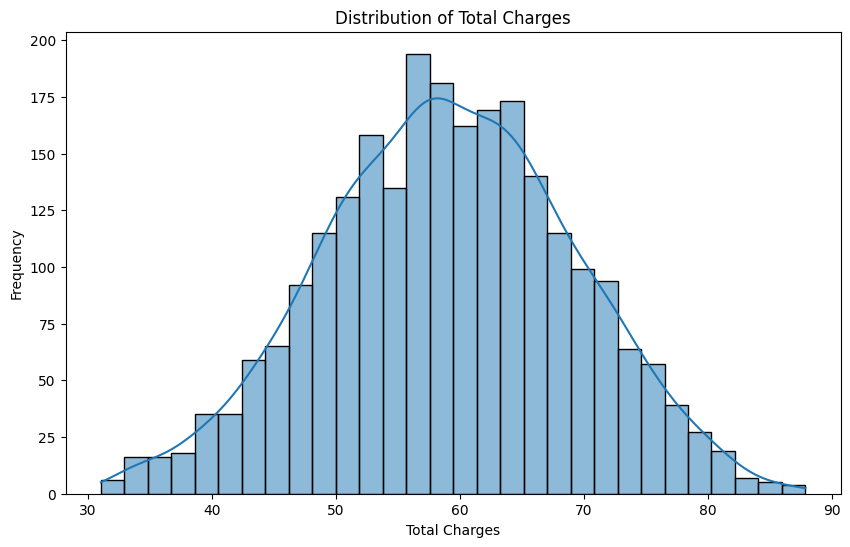

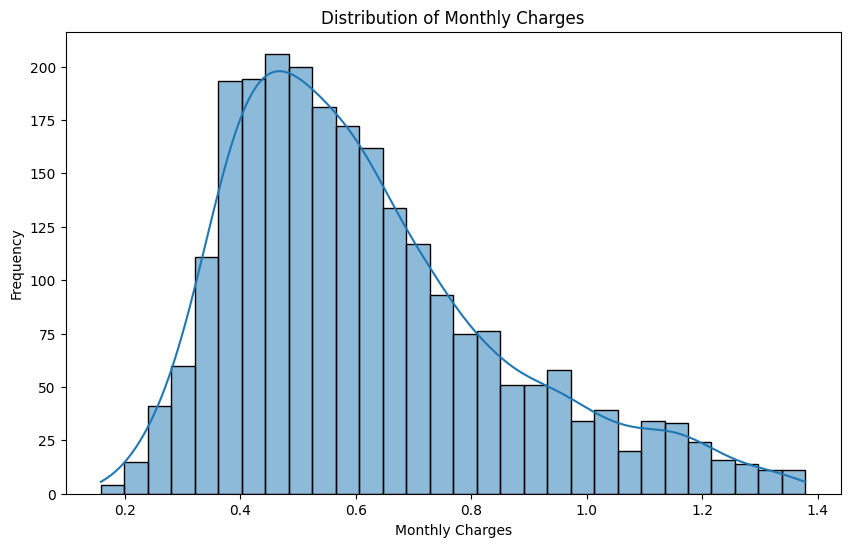

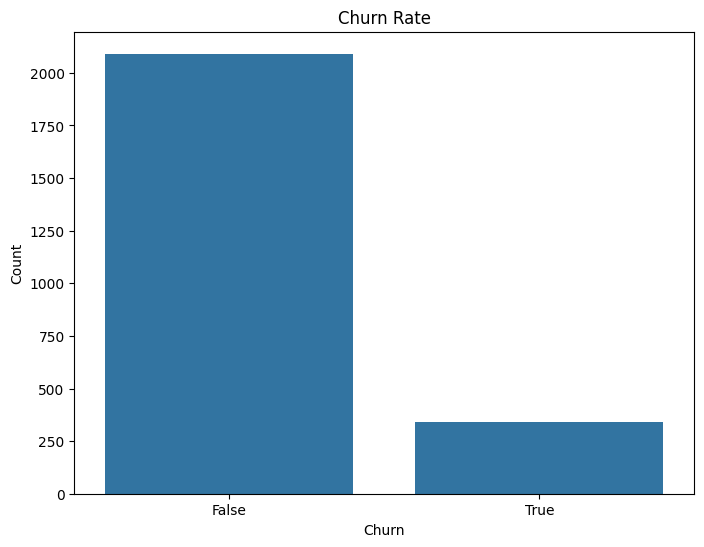

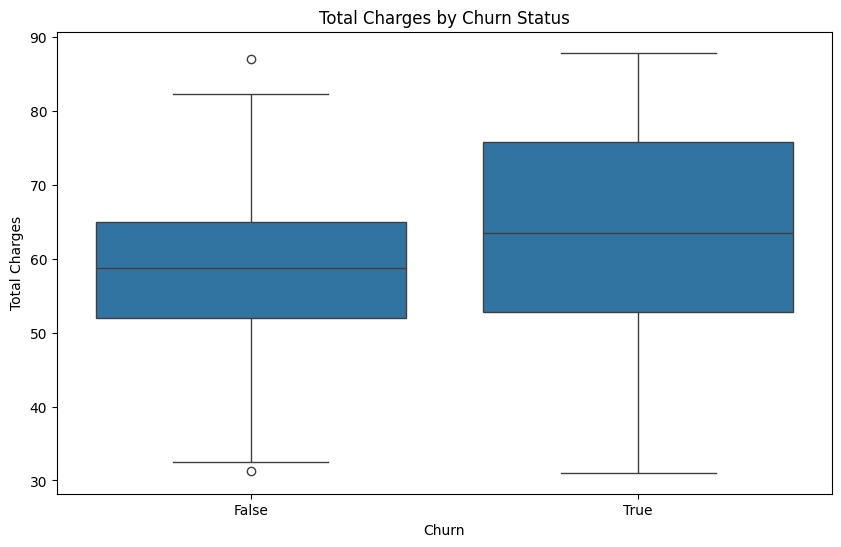

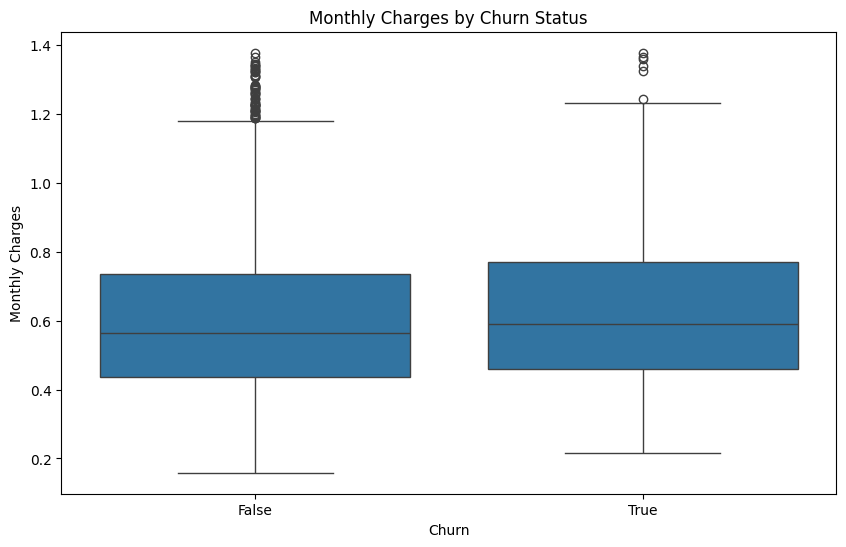

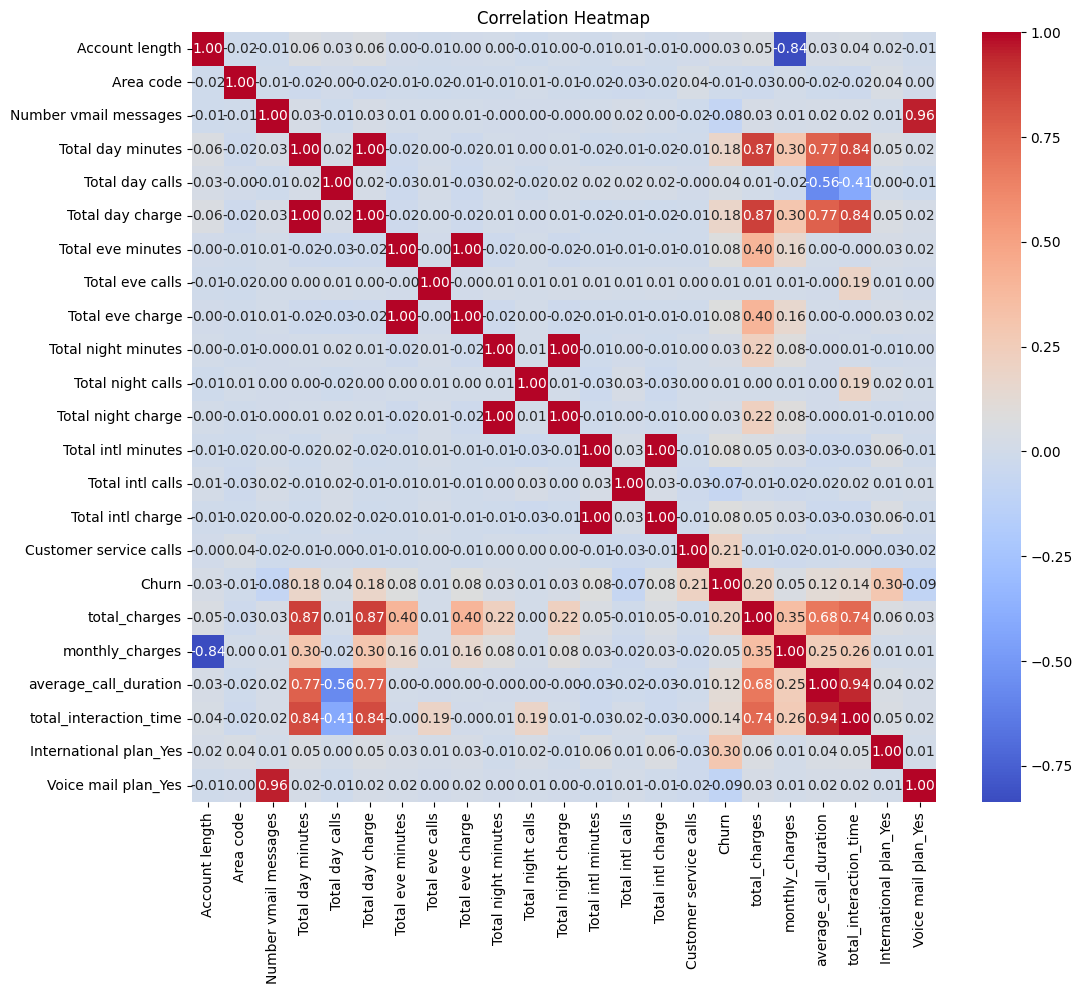

In [11]:
# EDA visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of Total Charges
plt.figure(figsize=(10, 6))
sns.histplot(train_df['total_charges'], kde=True, bins=30)
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.show()

# 2. Distribution of Monthly Charges
plt.figure(figsize=(10, 6))
sns.histplot(train_df['monthly_charges'], kde=True, bins=30)
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.show()

# 3. Churn rate
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=train_df)
plt.title('Churn Rate')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# 4. Total charges by churn status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='total_charges', data=train_df)
plt.title('Total Charges by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.show()

# 5. Monthly charges by churn status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='monthly_charges', data=train_df)
plt.title('Monthly Charges by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()

# 6. Correlation heatmap
plt.figure(figsize=(12, 10))
corr_matrix = train_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



In [ ]:
"""
Key Observations from correlation heatmap:
1. Total Charges and Monthly Charges have a strong positive correlation with each other.
2. Total Day Charge, Total Eve Charge, Total Night Charge, and Total Intl Charge are strongly correlated with Total Charges, which is expected as they contribute to the total charges.
3. Average Call Duration has a moderate correlation with Total Day Minutes and Total Day Calls.
4. Churn does not show strong correlation with most features, which indicates the necessity of more complex models for prediction.
"""

In [12]:
from sklearn.model_selection import train_test_split

# Define features and target
X = train_df.drop('Churn', axis=1)
y = train_df['Churn'].astype('int')  # Ensure the target is of integer type

# Split the dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")


Training set size: (1944, 22)
Validation set size: (486, 22)


In [14]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the training and validation sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reinitialize the models
log_reg = LogisticRegression(max_iter=2000)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train Logistic Regression
log_reg.fit(X_train_scaled, y_train)
log_reg_pred = log_reg.predict(X_val_scaled)

# Train Random Forest
rf_clf.fit(X_train, y_train)
rf_clf_pred = rf_clf.predict(X_val)

# Train XGBoost
xgb_clf.fit(X_train, y_train)
xgb_clf_pred = xgb_clf.predict(X_val)


Model: Logistic Regression
Accuracy: 0.8642
Precision: 0.6316
Recall: 0.1690
F1 Score: 0.2667
ROC-AUC: 0.5761


Model: Random Forest
Accuracy: 0.9712
Precision: 0.9831
Recall: 0.8169
F1 Score: 0.8923
ROC-AUC: 0.9072


Model: XGBoost
Accuracy: 0.9774
Precision: 1.0000
Recall: 0.8451
F1 Score: 0.9160
ROC-AUC: 0.9225




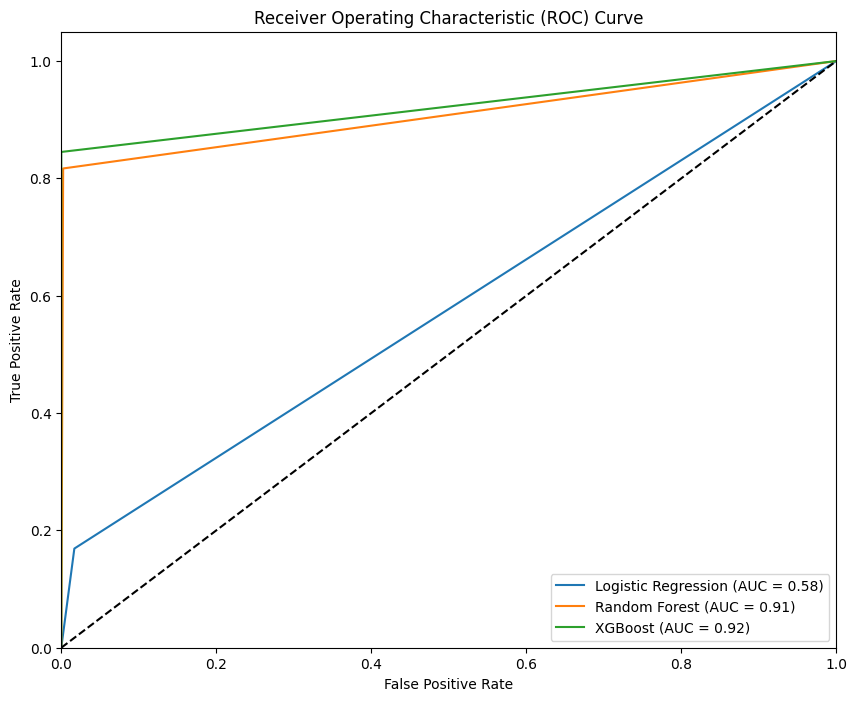

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to evaluate model performance
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\n")
    
    return accuracy, precision, recall, f1, roc_auc

# Evaluate Logistic Regression
log_reg_metrics = evaluate_model(y_val, log_reg_pred, "Logistic Regression")

# Evaluate Random Forest
rf_clf_metrics = evaluate_model(y_val, rf_clf_pred, "Random Forest")

# Evaluate XGBoost
xgb_clf_metrics = evaluate_model(y_val, xgb_clf_pred, "XGBoost")

# Plot ROC Curves
plt.figure(figsize=(10, 8))

models = [log_reg, rf_clf, xgb_clf]
model_names = ["Logistic Regression", "Random Forest", "XGBoost"]
preds = [log_reg_pred, rf_clf_pred, xgb_clf_pred]

for model, name, pred in zip(models, model_names, preds):
    fpr, tpr, _ = roc_curve(y_val, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


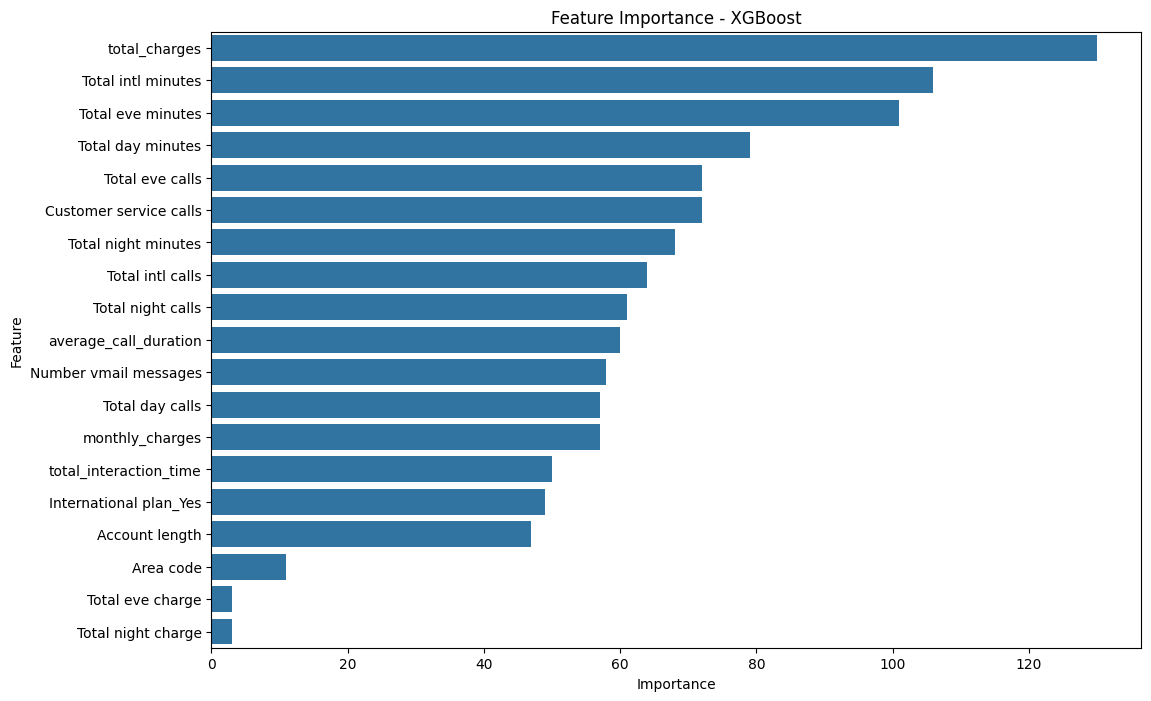

In [17]:
# Feature importance for XGBoost
xgb_importance = xgb_clf.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(xgb_importance.items(), key=lambda x: x[1], reverse=True)

# Convert to a DataFrame for better visualization
importance_df = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance'])

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - XGBoost')
plt.show()


In [18]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train XGBoost with the best parameters
xgb_best = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
xgb_best.fit(X_train, y_train)
xgb_best_pred = xgb_best.predict(X_val)

# Evaluate the tuned model
evaluate_model(y_val, xgb_best_pred, "XGBoost Tuned")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Model: XGBoost Tuned
Accuracy: 0.9774
Precision: 1.0000
Recall: 0.8451
F1 Score: 0.9160
ROC-AUC: 0.9225




(0.977366255144033,
 1.0,
 0.8450704225352113,
 0.916030534351145,
 0.9225352112676056)

In [19]:
# Print the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")


Best parameters found: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


In [20]:
# Train XGBoost with the best parameters
xgb_best = xgb.XGBClassifier(
    learning_rate=0.01,
    max_depth=5,
    n_estimators=200,
    subsample=1.0,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Scaling the data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Fit the model
xgb_best.fit(X_train_scaled, y_train)
xgb_best_pred = xgb_best.predict(X_val_scaled)

# Evaluate the tuned model
evaluate_model(y_val, xgb_best_pred, "XGBoost Tuned")


Model: XGBoost Tuned
Accuracy: 0.9774
Precision: 1.0000
Recall: 0.8451
F1 Score: 0.9160
ROC-AUC: 0.9225




(0.977366255144033,
 1.0,
 0.8450704225352113,
 0.916030534351145,
 0.9225352112676056)

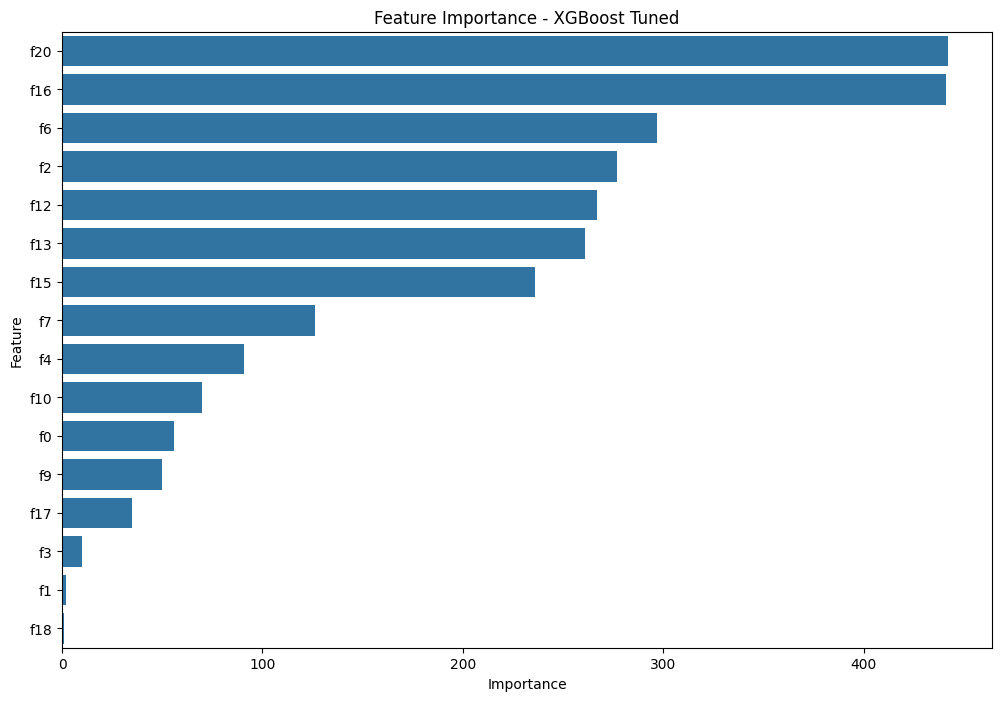

In [21]:
# Feature importance for the tuned XGBoost model
xgb_importance = xgb_best.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(xgb_importance.items(), key=lambda x: x[1], reverse=True)

# Convert to a DataFrame for better visualization
importance_df = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance'])

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - XGBoost Tuned')
plt.show()


In [22]:
# Combine training and validation sets for final model training
X_final_train = pd.concat([X_train, X_val])
y_final_train = pd.concat([y_train, y_val])

# Scale the combined training set
X_final_train_scaled = scaler.fit_transform(X_final_train)
X_test_scaled = scaler.transform(test_df.drop('Churn', axis=1))

# Train the final XGBoost model
xgb_final = xgb.XGBClassifier(
    learning_rate=0.01,
    max_depth=5,
    n_estimators=200,
    subsample=1.0,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit the final model
xgb_final.fit(X_final_train_scaled, y_final_train)
xgb_final_pred = xgb_final.predict(X_test_scaled)

# Evaluate the final model
y_test = test_df['Churn'].astype('int')
evaluate_model(y_test, xgb_final_pred, "XGBoost Final")


Model: XGBoost Final
Accuracy: 0.9802
Precision: 0.9865
Recall: 0.8690
F1 Score: 0.9241
ROC-AUC: 0.9336




(0.9801652892561984,
 0.9864864864864865,
 0.8690476190476191,
 0.9240506329113924,
 0.9335641166255368)

[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=300, 